In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pk
import os,glob,re
import tifffile
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import fpdf
from math import isnan

In [6]:
#create_msr_infodict
msr_info = pd.read_excel("/Users/jz-rolling/Desktop/AutoP/MSR_reference_new.xls")
MSR_dict = {}
for i in msr_info.index:
    plate = msr_info.iloc[i]["MSR_INDEX"]
    if plate == "PP1":
        plate = "MSR_PP1"
    if plate not in MSR_dict:
        MSR_dict[plate] = {}
    well = msr_info.iloc[i]["WELL_NO"]
    locus = msr_info.iloc[i]["MSMEG_####"]
    if not isnan(locus):
        locus = "MSMEG_{}".format(str(int(locus)).zfill(4))
        MSR_dict[plate][well] = locus

In [7]:
def read_gff(locus,gff):
    if locus in gff["Locus"].values:
        items = ["Start","Stop","Strand","Name","Product","UniProt_AC",'Orthologues M. tuberculosis']
        gene = gff[gff["Locus"]==locus].copy()
        return (gene[items].values[0])
    else:
        raise ValueError("Locus not found!")

def read_essentiality(locus,info_table):
    es_call_msm,es_call_mtb,\
    mtb_gene_name,mtb_gene_description = 'nan','nan','nan','nan' 
    if locus in msm_tnseq["Locus"].values:
        es_call_msm = es_conversion[int(msm_tnseq[msm_tnseq["Locus"]==locus]["Essentiality"].values[0])]
        mtb_ortholog = info_table[-1]
        if mtb_ortholog in mtb_tnseq["ORF ID"].values:
            mtb_gene = mtb_tnseq[mtb_tnseq["ORF ID"]==mtb_ortholog]
            es_call_mtb = mtb_gene["Final Call"].values[0]
            mtb_gene_name = mtb_gene["Name"].values[0]
            mtb_gene_description = mtb_gene["Description"].values[0]
    return es_call_msm,es_call_mtb,mtb_gene_name,mtb_gene_description
    
def reconstruct_operons(operon_df):
    operon_dict = {}
    for operon in operon_df.values:
        operon = operon[0][6:]
        split_genes = operon.split("-")
        for gene in split_genes:
            operon_dict["MSMEG_"+gene] = operon
    return operon_dict

def reconstruct_go(go_df):
    locus_list = set(go_df["Locus"].values)
    locus_dict = {}
    for locus in locus_list:
        locus_dict[locus] = "|".join(list(go_df[go_df["Locus"]==locus]["Description"].values))
    return locus_dict

def intersection(l1,l2):
    return(set(l1).intersection(set(l2)))

In [8]:
gff = pd.read_excel("/Volumes/Sam/info/msm_gff.xls")
msm_tnseq = pd.read_excel("/Volumes/Sam/info/msm_tnseq.xlsx")
mtb_tnseq = pd.read_excel("/Volumes/Sam/info/mtb_tnseq.xlsx")
es_conversion = {1:"NE",2:"ES",3:"DE"}
operon_df = pd.read_excel("/Volumes/Sam/info/msm_operon.xlsx")
go_df = pd.read_excel("/Volumes/Sam/info/smegmatis_GO_terms_08_28_2017.xlsx")
operon_dict = reconstruct_operons(operon_df)
go_dict = reconstruct_go(go_df)

In [9]:
#create_msr_pathdict
path_dict = {}
plates = glob.glob("/Volumes/Sam/MSR*_IDW/")
for plate in plates:
    plate_name = plate.split("/")[-2][:-4]
    if plate_name not in path_dict:
        path_dict[plate_name] = {}
    subfolder = glob.glob(plate+"*raw_files/")[0]
    if len(glob.glob(subfolder+"*raw_files/")) > 0:
        babyfolders = glob.glob(subfolder+"*raw_files/")
        for babyfolder in babyfolders:
            wells = glob.glob(babyfolder+"output/Well*/")
            batch = babyfolder.split("/")[-2][:-10]
            if len(wells)>0:
                for well_folder in wells:
                    well = well_folder.split("/")[-2][-3:]
                    if well in path_dict[plate_name]:
                        path_dict[plate_name][well].append(well_folder)
                    else:
                        path_dict[plate_name][well] = [well_folder]
    else:
        wells = glob.glob(subfolder+"output/Well*/")
        batch = subfolder.split("/")[-2][:-10]
        if len(wells)>0:
            for well_folder in wells:
                well = well_folder.split("/")[-2][-3:]
                if well in path_dict[plate_name]:
                    path_dict[plate_name][well].append(well_folder)
                else:
                    path_dict[plate_name][well] = [well_folder]

In [44]:
from fpdf import FPDF
def add_image(pdf,img,x,y,w):
    pdf.image(img,x=x,y=y,w=w)

In [43]:
def frame_page(pdf,locus,img,plate,well,batch):
    info_table = read_gff(locus,gff)
    name,product,up_id,mtb_ortholog = str(info_table[3]),str(info_table[4]),str(info_table[5]),str(info_table[6])
    es_call_msm,es_call_mtb,\
    mtb_gene_name,mtb_gene_description = read_essentiality(locus,info_table)
    if locus in operon_dict:
        operon = operon_dict[locus]
    else:
        operon = "nan"
    
    if locus in go_dict:
        go = go_dict[locus]
    else:
        go = "nan"
    pdf.add_page()
    pdf.set_line_width(0.8)
    pdf.line(20,172,185,172)
    pdf.line(20,210,185,210)
    add_image(pdf,img,20,3,170)
    pdf.cell(5,163,ln=1)
    pdf.cell(10,7)
    pdf.cell(80,7,"Plate: {}, well: {}, batch: {}.".format(plate,well,batch),\
             border = 0,ln=1)
    pdf.cell(10,7)
    
    pdf.cell(80,7,"Locus: Msm | Mtb: {} | {}.  Uniprot: {}.".format(locus,mtb_ortholog,up_id),\
             border = 0,ln=1)
    pdf.cell(10,7)
    pdf.cell(80,7,"Name: Msm | Mtb: {} | {}.".format(name,mtb_gene_name),\
             border = 0,ln=1)
    pdf.cell(10,7)
    pdf.cell(80,7,"Essentiality: Msm | Mtb: {} | {}.".format(es_call_msm,es_call_mtb),\
             border = 0,ln=1)
    pdf.cell(10,7)
    pdf.cell(80,7,"Operon: {}.".format(operon),border = 0,ln=1)
    pdf.cell(10,4,ln=1)
    i = 0
    while i < len(product):
        if i == 0:
            substr = "Product: "+product[i:min(i+64,len(product))]
            i += 64
        else:
            substr = " "*12+product[i:min(i+64,len(product))]
            i += 64
        pdf.cell(10,8)
        pdf.cell(80,8,substr,border = 0,ln=1)
    j = 0
    while j < len(go):
        if j == 0:
            substr = "GO     : "+go[j:min(j+64,len(go))]
            j+=64
        else:
            substr = " "*12+go[j:min(j+64,len(go))]
            j+=64
        pdf.cell(10,8)
        pdf.cell(80,8,substr,border = 0,ln=1)

In [359]:
locus = "MSMEG_0001"
plate = "test"
well = "test"
batch = "test"
img="/Users/jz-rolling/Desktop/not_enough_cells.png"
pdf = FPDF(orientation='P', unit='mm', format='A4')
pdf.set_font('Arial', size=13)
for i in range(1,5):
    locus = "MSMEG_"+str(i).zfill(4)
    #print(locus)
    frame_page(pdf,locus,img,plate,well,batch)

In [280]:
read_gff("MSMEG_0001",gff)[4]

'DNA polymerase III, beta subunit'

In [366]:
coords = [[5,5],[100,5],[5,130],[100,130]]
for plate,wells in path_dict.items():
    pdf = FPDF(orientation='P', unit='mm', format='A4')
    pdf.set_font('Arial', size=13)
    for well,well_folders in wells.items():
        if well not in MSR_dict[plate]:
                print("Plate {}, well {} is supposed to be empty!".format(plate,well))
        else:
            for folder in well_folders:
                batch = folder.split("/")[-4][:-10]
                summary_plot = glob.glob(folder+"summary_plot.png")
                if len(summary_plot) == 1:
                    img = summary_plot[0]
                else:
                    img = "/Users/jz-rolling/Desktop/not_enough_cells.png"
                locus = MSR_dict[plate][well]
                frame_page(pdf,locus,img,plate,well,batch)
                cell_plots = glob.glob(folder+"*extensive_plot.png")
                if len(cell_plots) > 0:
                    pdf.add_page()
                    _idx = np.arange(len(cell_plots))
                    np.random.shuffle(_idx)
                    for i in range(min(4,len(_idx))):
                        (x,y) = coords[i]
                        w = 95
                        plot = cell_plots[_idx[i]]
                        add_image(pdf,plot,x,y,w)
    pdf.output("/Volumes/Sam/summary/{}.pdf".format(plate))

Plate MSR11, well H12 is supposed to be empty!
Plate MSR1, well B07 is supposed to be empty!
Plate MSR1, well C10 is supposed to be empty!
Plate MSR1, well E08 is supposed to be empty!
Plate MSR1, well G10 is supposed to be empty!
Plate MSR3, well C07 is supposed to be empty!
Plate MSR6, well A05 is supposed to be empty!
Plate MSR6, well G06 is supposed to be empty!
Plate MSR7, well D05 is supposed to be empty!
Plate MSR9, well E02 is supposed to be empty!


In [26]:
pdf.output("/Users/jz-rolling/Desktop/img.pdf")

''

In [316]:
pdf.get_string_width("/Users/jz-rolling/Desktop/img.pdf")

66.0033111111111

In [12]:
hits = pd.read_excel("/Users/jz-rolling/Desktop/summary/hits_clustered.xls")
hits[hits["Group"] <= 2]["Sample_id"].values

array(['MSR12_10242019_Well_F04', 'MSR13_10182019_Well_H07',
       'MSR2_07092019_Well_D12', 'MSR2_08232019_Well_D03',
       'MSR3_05202019_batch2_Well_C11', 'MSR4_08202019_batch1_Well_G06',
       'MSR6_07232018_Well_D03', 'MSR6_07242018_Well_D03',
       'MSR8_07252019_Well_E07', 'MSR8_07252019_Well_F01',
       'MSR_PP1_07072018_Well_A07', 'MSR_PP1_07072018_Well_A12',
       'MSR_PP1_07072018_Well_B02', 'MSR_PP1_07072018_Well_B04',
       'MSR_PP1_07072018_Well_B07', 'MSR_PP1_07072018_Well_B09',
       'MSR_PP1_07072018_Well_C02', 'MSR_PP1_07072018_Well_C12',
       'MSR_PP1_07072018_Well_D01', 'MSR_PP1_07072018_Well_D02',
       'MSR_PP1_07072018_Well_D03', 'MSR_PP1_07072018_Well_D05',
       'MSR_PP1_07072018_Well_D07', 'MSR_PP1_07072018_Well_D08',
       'MSR_PP1_07072018_Well_E01', 'MSR_PP1_07072018_Well_E02',
       'MSR_PP1_07072018_Well_E03', 'MSR_PP1_07072018_Well_E05',
       'MSR_PP1_07072018_Well_E07', 'MSR_PP1_07072018_Well_E09',
       'MSR_PP1_07072018_Well_E11', 'MS

In [15]:
coords = [[5,5],[100,5],[5,130],[100,130]]
pattern = re.compile("MSR")
for i in set(hits["Group"].values):
    samples = hits[hits["Group"] == i]["Sample_id"].values
    print(len(samples))
    pdf = FPDF(orientation='P', unit='mm', format='A4')
    pdf.set_font('Arial', size=13)
    for plate,wells in path_dict.items():
        for well,well_folders in wells.items():
            for folder in well_folders:
                batch = folder.split("/")[-4][:-10]
                sample_id = "{}_{}_Well_{}".format(plate,batch,well)
                if sample_id in samples:
                    print("Group, {}, {}".format(i,sample_id))
                    summary_plot = glob.glob(folder+"summary_plot.png")
                    if len(summary_plot) == 1:
                        img = summary_plot[0]
                    else:
                        img = "/Users/jz-rolling/Desktop/not_enough_cells.png"
                    try:
                        locus = MSR_dict[plate][well]
                        frame_page(pdf,locus,img,plate,well,batch)
                        cell_plots = glob.glob(folder+"*extensive_plot.png")
                        if len(cell_plots) > 0:
                            pdf.add_page()
                            _idx = np.arange(len(cell_plots))
                            np.random.shuffle(_idx)
                            for j in range(min(4,len(_idx))):
                                (x,y) = coords[j]
                                w = 95
                                plot = cell_plots[_idx[j]]
                                add_image(pdf,plot,x,y,w)
                    except:
                        continue
    pdf.output("/Volumes/Sam/summary/Group_{}.pdf".format(i))

6
Group, 0, MSR_PP1_07072018_Well_A07
Group, 0, MSR_PP1_07072018_Well_B07
Group, 0, MSR_PP1_07072018_Well_C12
Group, 0, MSR_PP1_07072018_Well_D01
Group, 0, MSR_PP1_07072018_Well_E01
Group, 0, MSR_PP1_07072018_Well_E04
6
Group, 1, MSR8_07252019_Well_F01
Group, 1, MSR_PP1_07072018_Well_A12
Group, 1, MSR_PP1_07072018_Well_D08
Group, 1, MSR_PP1_07072018_Well_E02
Group, 1, MSR_PP1_07072018_Well_E09
Group, 1, MSR_PP1_07072018_Well_G06
7
Group, 2, MSR5_08022019_Well_G11
Group, 2, MSR9_07192019_Well_B08
Group, 2, MSR_PP1_07072018_Well_B12
Group, 2, MSR_PP1_07072018_Well_D09
Group, 2, MSR_PP1_07072018_Well_D12
Group, 2, MSR_PP1_07072018_Well_F09
Group, 2, MSR_PP1_07072018_Well_F12
40
Group, 3, MSR10_07102019_Well_B02
Group, 3, MSR10_08162019_Well_G11
Group, 3, MSR11_08092019_Well_B10
Group, 3, MSR12_07272019_Well_A05
Group, 3, MSR12_07272019_Well_A07
Group, 3, MSR12_07272019_Well_B05
Group, 3, MSR12_07272019_Well_C05
Group, 3, MSR12_07272019_Well_D07
Group, 3, MSR13_10182019_Well_A07
Group, 3, 

In [360]:
pdf.add_page()
add_image(pdf,"/Volumes/Sam/MSR2_IDW/plate2_raw_files/08232019_raw_files/output/Well_A01/MSR2_A01_0_0_45_0_extensive_plot.png",5,5,95)
add_image(pdf,"/Volumes/Sam/MSR2_IDW/plate2_raw_files/08232019_raw_files/output/Well_A01/MSR2_A01_0_0_45_0_extensive_plot.png",100,5,95)
add_image(pdf,"/Volumes/Sam/MSR2_IDW/plate2_raw_files/08232019_raw_files/output/Well_A01/MSR2_A01_0_0_45_0_extensive_plot.png",5,130,95)
add_image(pdf,"/Volumes/Sam/MSR2_IDW/plate2_raw_files/08232019_raw_files/output/Well_A01/MSR2_A01_0_0_45_0_extensive_plot.png",100,130,95)

In [12]:
n = 0
for k,v in MSR_dict.items():
    n+= len(v)

In [10]:
coords = [[5,5],[100,5],[5,130],[100,130]]
plate = "MSR13"
wells = path_dict[plate]
try:
    pdf = FPDF(orientation='P', unit='mm', format='A4')
    pdf.set_font('Arial', size=13)
    for well,well_folders in wells.items():
        if well not in MSR_dict[plate]:
                print("Plate {}, well {} is supposed to be empty!".format(plate,well))
        else:
            for folder in well_folders:
                batch = folder.split("/")[-4][:-10]
                summary_plot = glob.glob(folder+"summary_plot.png")
                if len(summary_plot) == 1:
                    img = summary_plot[0]
                else:
                    img = "/Users/jz-rolling/Desktop/not_enough_cells.png"
                locus = MSR_dict[plate][well]
                frame_page(pdf,locus,img,plate,well,batch)
                cell_plots = glob.glob(folder+"*extensive_plot.png")
                if len(cell_plots) > 0:
                    pdf.add_page()
                    _idx = np.arange(len(cell_plots))
                    np.random.shuffle(_idx)
                    for i in range(min(4,len(_idx))):
                        (x,y) = coords[i]
                        w = 95
                        plot = cell_plots[_idx[i]]
                        add_image(pdf,plot,x,y,w)
    pdf.output("/Volumes/Sam/summary/{}.pdf".format(plate))
except:
    print("Error found")

In [23]:
def summary_plot(heatmap,lateral_mean,\
                 lateral_std,\
                 filtered_data,\
                 global_mean_dict,\
                 output_folder):
    sns.set(font_scale = 1,style ="white")
    fig = plt.figure(figsize=(8, 8))
    gs = GridSpec(40, 40)
    ax1 = fig.add_subplot(gs[2:24, 0:11])
    ax1.imshow(heatmap,cmap = "viridis",aspect="auto")
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_title("Normalized demograph\n(max length = 15μm)\nN=%d"%(len(heatmap)), fontsize=12)
    ax2 = fig.add_subplot(gs[26:36, 0:11])
    average_width = filtered_data["Cell width mean [um]"].mean()
    x_lateral = np.linspace(-0.5 * average_width, 0.5 * average_width, 100)
    ax2.plot(x_lateral,lateral_mean)
    ax2.fill_between(x_lateral, lateral_mean - lateral_std, lateral_mean + lateral_std, alpha=0.1)
    ax2.set_xlabel("Distance to midline [μm]", fontsize=12)
    ax2.text(0.5, 0.1, "normalized fluorecence\nalong lateral axis", fontsize=10,\
             horizontalalignment='center', transform=ax2.transAxes,\
             bbox=dict(facecolor='white', alpha=0.4))
    ax2.get_yaxis().set_visible(False)
    scatter_plot_with_global_metric(fig,gs,[0,10,15,40],\
                                    global_mean_dict,filtered_data,\
                                    "Length [um]","Cell width mean [um]",\
                                    xrange=np.linspace(0,15,6),\
                                    yrange=np.linspace(0.2,1.2,6),dist_plot=True)
    scatter_plot_with_global_metric(fig,gs,[13,23,15,40],\
                                    global_mean_dict,filtered_data,\
                                    "Fluorescent intensity mean","Length [um]",\
                                    yrange=np.linspace(0,15,6),dist_plot=True)
    scatter_plot_with_global_metric(fig,gs,[26,36,15,25],\
                                    global_mean_dict,filtered_data,\
                                    "Centrifugality","Membrane index",\
                                    xrange = np.linspace(-3,3,7),yrange=np.linspace(0.1,0.8,8),\
                                    dist_plot=True,dist_height=2)
    scatter_plot_with_global_metric(fig,gs,[26,36,29,39],\
                                    global_mean_dict,filtered_data,\
                                    "Signal variability","Pole symmetry",\
                                    xrange=np.linspace(0,1,6),yrange=np.linspace(0,1,6),\
                                    dist_plot=True,dist_height=2)
    fig.savefig(output_folder+"summary_plot.png",bbox_inches='tight',dpi=200)
    plt.close()

In [14]:
def retrieve_group_path(group,hits=hits,path_dict=path_dict,MSR_dict = MSR_dict):
    group_path = []
    locus_list = []
    for sample in hits[hits["Group"]==group]["Sample_id"]:
        well = sample[-3:]
        plate = sample.split("_")[0]
        batch = sample.split("_")[1]
        if plate == "MSR":
            plate = "_".join(sample.split("_")[:2])
            batch = sample.split("_")[2]
        try:
            locus = MSR_dict[plate][well]
            info_table = read_gff(locus,gff)
            name = str(info_table[3])
        except:
            locus,name = "nan","nan"
        for path in path_dict[plate][well]:
            if batch in path:
                group_path.append(path)
                locus_list.append([locus,name])
    return(group_path,locus_list)

In [26]:
def group_heatmap(group_list,locus_list,group):
    n_rows = int(len(group_list)/8)+1
    n_cols = min(len(group_list),8)
    fig = plt.figure(figsize=(n_cols*2, n_rows*4))
    gs = GridSpec(16*n_rows,8*n_cols)
    for r in range(n_rows):
        for c in range(n_cols):
            n = 8*r+c
            if n >= len(group_list):
                break
            path = group_list[n]
            axial_data = np.load(glob.glob(path+"*demograph.npy")[0])
            well_summary = pd.read_excel(glob.glob(path+"*.xls")[0])
            filtered_data = well_summary[well_summary["SNR"]>2.5]
            heatmap = axial_data[filtered_data.sort_values(by="Length [um]")["Index"]]
            ax1 = fig.add_subplot(gs[16*r+1:16*r+16, 8*c:8*c+8])
            ax1.imshow(heatmap,cmap = "viridis",aspect="auto")
            ax1.get_xaxis().set_visible(False)
            ax1.get_yaxis().set_visible(False)
            (locus,name) = locus_list[n]
            if name != locus:
                locus = locus+"|"+name
            ax1.set_title(locus, fontsize=10)
        if n >= len(group_list):
                break
    fig.savefig("/Volumes/Sam/summary/Group_{}_heatmap.png".format(group),bbox_inches = "tight",dpi = 200)

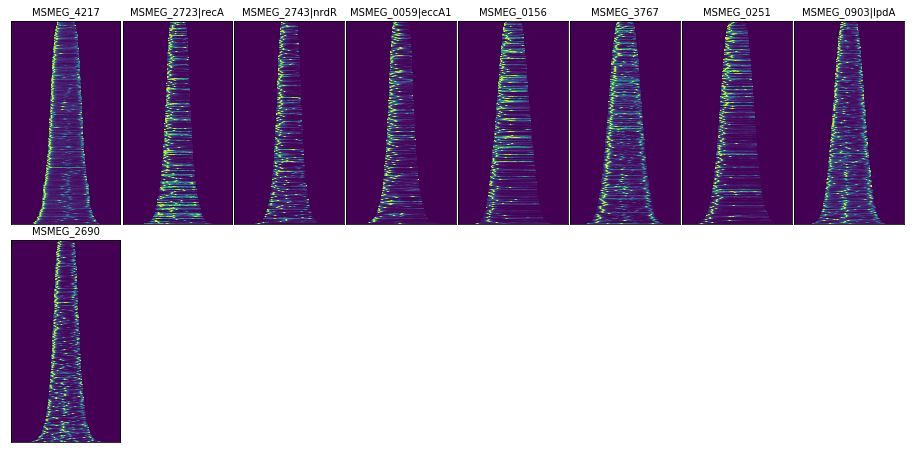

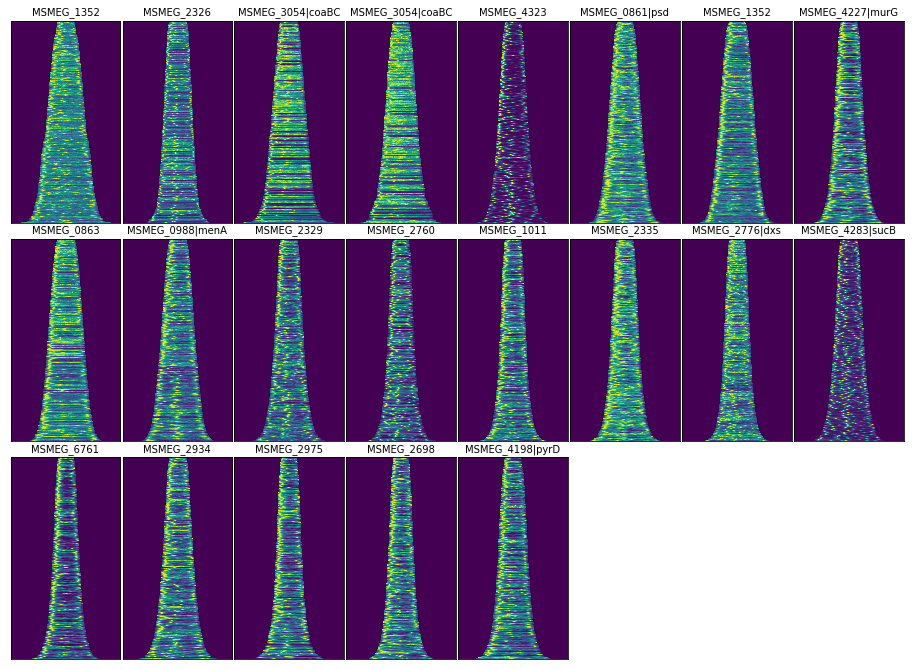

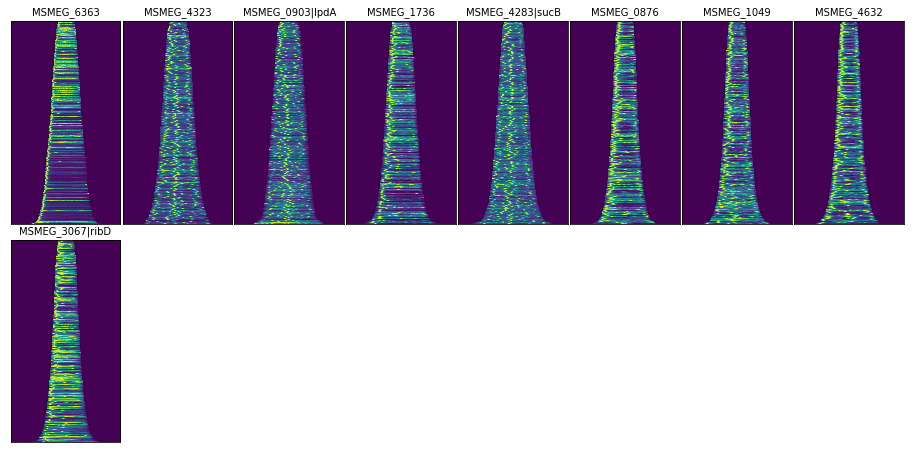

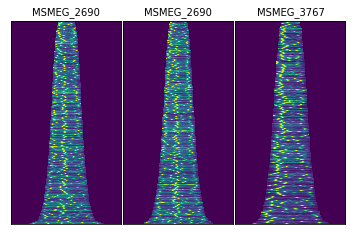

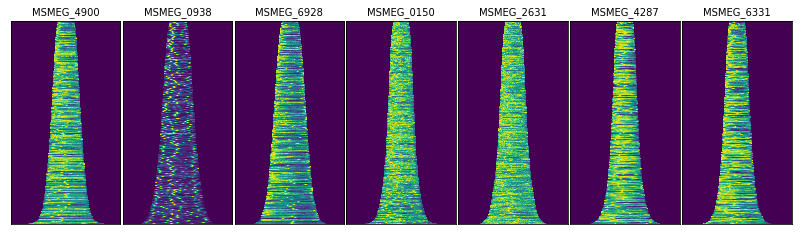

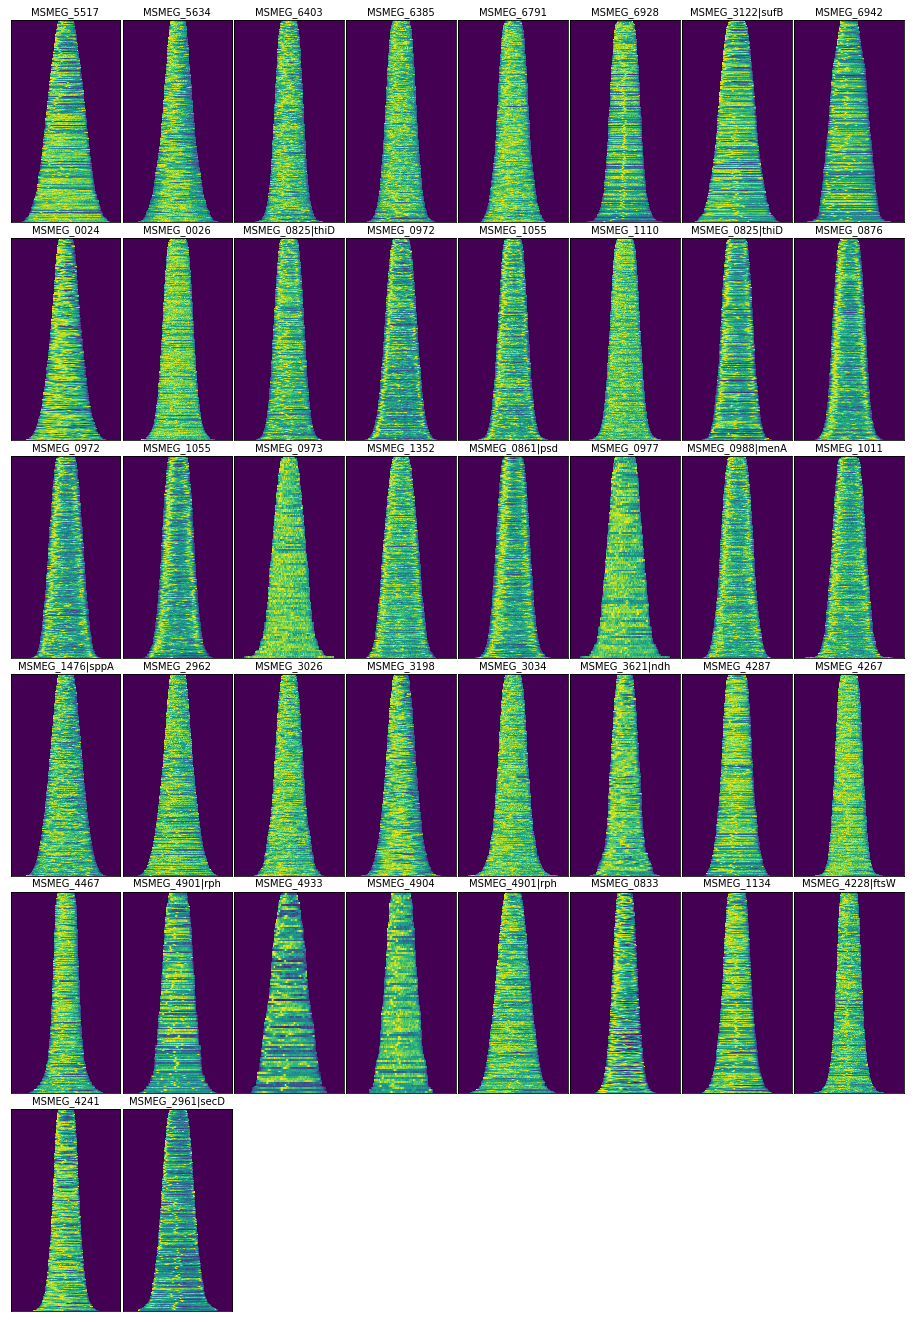

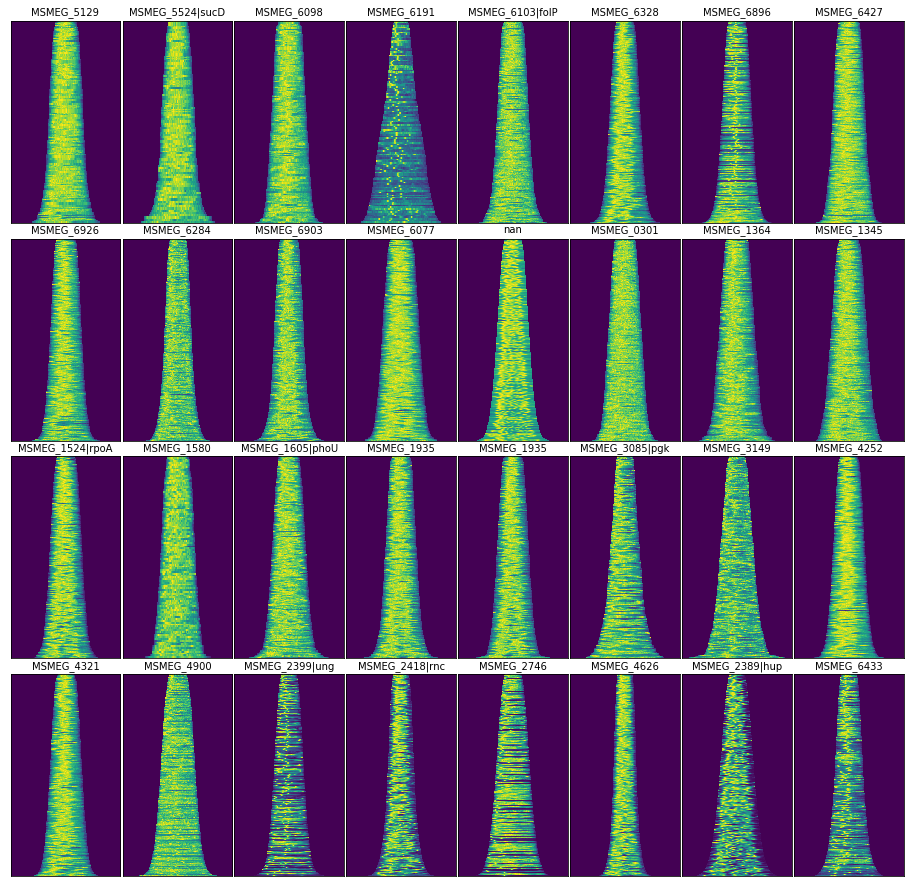

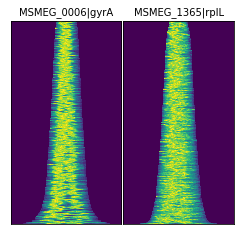

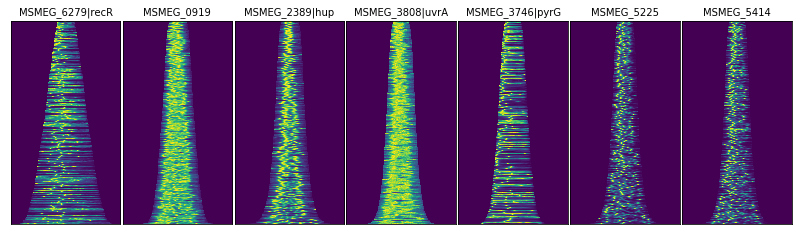

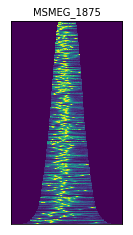

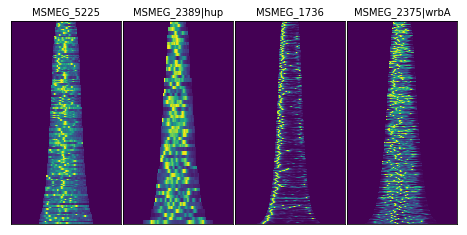

In [28]:
for group in set(hits["Group"]):
    group_path,locus_list = retrieve_group_path(group)
    group_heatmap(group_path,locus_list,group)

In [25]:
group_path

['/Volumes/Sam/MSR12_IDW/MSR12_raw_files/10242019_raw_files/output/Well_F04/',
 '/Volumes/Sam/MSR13_IDW/10182019_raw_files/output/Well_H07/',
 '/Volumes/Sam/MSR2_IDW/plate2_raw_files/08232019_raw_files/output/Well_D03/',
 '/Volumes/Sam/MSR3_IDW/plate3_raw_files/05202019_batch2_raw_files/output/Well_C11/',
 '/Volumes/Sam/MSR8_IDW/plate8_raw_files/07252019_raw_files/output/Well_E07/',
 '/Volumes/Sam/MSR_PP1_IDW/07072018_raw_files/output/Well_D02/',
 '/Volumes/Sam/MSR_PP1_IDW/07072018_raw_files/output/Well_F03/',
 '/Volumes/Sam/MSR_PP1_IDW/07072018_raw_files/output/Well_F10/',
 '/Volumes/Sam/MSR_PP1_IDW/07072018_raw_files/output/Well_H07/']

In [32]:
pmf = pd.read_excel("/Volumes/Sam/info/pmf.xlsx")
pmf_refined = pd.read_excel("/Volumes/Sam/info/refined_pmf.xlsx")
pmcw = pd.read_excel("/Volumes/Sam/info/pm_cw.xlsx")

In [33]:
def read_YASU_data(df):
    output = []
    for val in df["MSMEG_"].values:
        if "\n" not in str(val):
            output.append("MSMEG_"+ str(int(val)).zfill(4))
        else:
            vals = val.split("\n")
            for locus in vals:
                output.append("MSMEG_"+ str(int(locus)).zfill(4))
    return output

In [38]:
pmf_list = read_YASU_data(pmf)
pmf_refined_list = read_YASU_data(pmf_refined)
pmcw_list = read_YASU_data(pmcw)
pmf_final = set(pmf_list).union(pmf_refined_list)

In [32]:
reverse_MSR_dict = {}
for i in msr_info.index:
    plate = msr_info.iloc[i]["MSR_INDEX"]
    if plate == "PP1":
        plate = "MSR_PP1"
    well = msr_info.iloc[i]["WELL_NO"]
    locus = msr_info.iloc[i]["MSMEG_####"]
    if not isnan(locus):
        locus = "MSMEG_{}".format(str(int(locus)).zfill(4))
        if locus not in reverse_MSR_dict:
            reverse_MSR_dict[locus] = [[plate,well]]
        else:
            reverse_MSR_dict[locus].append([plate,well])

In [47]:
coords = [[5,5],[100,5],[5,130],[100,130]]
pdf = FPDF(orientation='P', unit='mm', format='A4')
pdf.set_font('Arial', size=13)
for locus in pmf_final:
    if locus in reverse_MSR_dict:
        for coord in reverse_MSR_dict[locus]:
            plate,well = coord[0],coord[1]
            #enter_plate:
            if well in path_dict[plate]:
                paths = path_dict[plate][well]
                for folder in paths:
                    batch = folder.split("/")[-4][:-10]
                    summary_plot = glob.glob(folder+"summary_plot.png")
                    if len(summary_plot) == 1:
                        img = summary_plot[0]
                    else:
                        img = "/Users/jz-rolling/Desktop/not_enough_cells.png"
                    summary_data = pd.read_excel(folder+"Well_{}_summary.xls".format(well))
                    if summary_data["SNR"].mean() >= 3:
                        frame_page(pdf,locus,img,plate,well,batch)
                        cell_plots = glob.glob(folder+"*extensive_plot.png")
                        if len(cell_plots) > 0:
                            pdf.add_page()
                            _idx = np.arange(len(cell_plots))
                            np.random.shuffle(_idx)
                            for i in range(min(4,len(_idx))):
                                (x,y) = coords[i]
                                w = 95
                                plot = cell_plots[_idx[i]]
                                add_image(pdf,plot,x,y,w)
pdf.output("/Volumes/Sam/summary/pmf_refined.pdf")

''

In [48]:
hits = pd.read_excel("/Volumes/Sam/summary/hits_clustered.xls")

In [30]:
group_1_hits = []
for val in hits[hits["Group"]==1]["Sample_id"].values:
    val = val.split("_")
    plate = val[0]
    if plate == "MSR":
        plate = "MSR_PP1"
    well = val[-1]
    locus = MSR_dict[plate][well]
    group_1_hits.append(locus)

In [136]:
MSRIMD_X_pmf = intersection(group_1_hits,pmf_list)
MSRIMD_X_pmfrefined = intersection(group_1_hits,pmf_refined_list)
MSRIMD_X_pmffinal = intersection(group_1_hits,pmf_final)

In [116]:
len(MSRIMD_X_pmf),len(MSRIMD_X_pmfrefined),len(pmf_final)

(9, 12, 437)

In [141]:
len(set(manual_yasu).union(set(group_1_hits))-set(pmf_final))

15

In [137]:
len(set(MSRIMD_X_pmffinal))

13

In [131]:
len(set(group_1_hits))

19

In [138]:
len(intersection(manual_yasu,MSRIMD_X_pmffinal))

13

In [55]:
manual_list = glob.glob("/Users/jz-rolling/Desktop/summary/Manual_cluster/YASU/*.png")
manual_yasu = []
for item in manual_list:
    locus = "MSMEG_{}".format(item.split("_")[-2])
    manual_yasu.append(locus)
manual_yasu = set(manual_yasu)

In [56]:
manual_X_pmffinal = intersection(manual_yasu,pmf_final)

In [139]:
len(manual_X_pmffinal),len(manual_yasu)

(20, 32)

In [59]:
manual_X_auto = intersection(manual_yasu,group_1_hits)

In [143]:
len(manual_X_auto),len(set(group_1_hits))

(16, 19)

In [64]:
combined = set(group_1_hits).union(manual_yasu)

In [112]:
list1,list2,list3 = [0]*len(combined),[0]*len(combined),[0]*len(combined)
names,annotation = [],[]
for i in range(len(combined)):
    locus = list(combined)[i]
    if locus in group_1_hits:
        list1[i] += 1
    if locus in manual_yasu:
        list2[i] += 1    
    if locus in pmf_final:
        list3[i] += 1  
    annotation.append(gff[gff["Locus"]==locus]["Product"].values[0])
    name = (gff[gff["Locus"]==locus]["Name"].values[0])
    if name == locus:
        names.append("-")
    else:
        names.append(name)
yasudf = pd.DataFrame({"Locus":list(combined),\
                       "Identified by auto-clustering":list1,\
                       "Manually labled":list2,\
                       "Identified as PMF protein":list3,\
                       "Name":names,\
                       "Product":annotation})

In [114]:
yasudf.to_excel("/Users/jz-rolling/Desktop/summary/YASU_final.xls")

In [95]:
coords = [[5,5],[100,5],[5,130],[100,130]]
pdf = FPDF(orientation='P', unit='mm', format='A4')
pdf.set_font('Arial', size=13)
for locus in outlier:
    if locus in reverse_MSR_dict:
        for coord in reverse_MSR_dict[locus]:
            plate,well = coord[0],coord[1]
            #enter_plate:
            if well in path_dict[plate]:
                paths = path_dict[plate][well]
                for folder in paths:
                    batch = folder.split("/")[-4][:-10]
                    summary_plot = glob.glob(folder+"summary_plot.png")
                    if len(summary_plot) == 1:
                        img = summary_plot[0]
                    else:
                        img = "/Users/jz-rolling/Desktop/not_enough_cells.png"
                    summary_data = pd.read_excel(folder+"Well_{}_summary.xls".format(well))
                    if summary_data["SNR"].mean() >= 3:
                        frame_page(pdf,locus,img,plate,well,batch)
                        cell_plots = glob.glob(folder+"*extensive_plot.png")
                        if len(cell_plots) > 0:
                            pdf.add_page()
                            _idx = np.arange(len(cell_plots))
                            np.random.shuffle(_idx)
                            for i in range(min(4,len(_idx))):
                                (x,y) = coords[i]
                                w = 95
                                plot = cell_plots[_idx[i]]
                                add_image(pdf,plot,x,y,w)
pdf.output("/Volumes/Sam/summary/pmf_novel.pdf")

''

In [5]:
cd ~/PycharmProjects/IMyG_2/

/Users/jz-rolling/PycharmProjects/IMyG_2


In [6]:
import IMyG as im

In [ ]:
folders = glob.glob("/Volumes/Sam/MSR1_IDW/plate1_raw_files/11032019_raw_files/output/*/")
for folder in folders:
    header = folder.split("/")[-2].split("_")[-1]
    header = header[0] + header[1:].zfill(2)
    locus = MSR_dict["MSR1"][header]
    #im.IO.read_from_folder(folder,header)
    im.IO.create_metrics_folder(folder,"/Users/jz-rolling/Desktop/summary/Manual_cluster/",locus,"FITC",all_cells=True,re_align = True,max_th=0)

In [5]:
dnar = pd.read_excel("/Users/jz-rolling/Desktop/summary/DNArepairRv.xlsx")

In [15]:
homologs = {}
for i in gff.index:
    msm = gff.iloc[i]["Locus"]
    mtb = gff.iloc[i]["Orthologues M. tuberculosis"]
    if str(mtb).startswith("Rv"):
        if mtb not in homologs:
            homologs[mtb] = [msm]
        else:
            homologs[mtb].append(msm)

In [21]:
out = []
for locus in dnar["Locus"]:
    if locus in homologs:
        msm = homologs[locus]
        out += msm

In [23]:
pd.DataFrame(out).to_excel("/Users/jz-rolling/Desktop/summary/DNArmsm.xls")